# V - Merging esbae with CEO phase I data 
### This script serves to merge validated data from CEO with eSBAE points for quick estimation of areas
#### This script requires minimum an m16 instance and select the python 3 kernel
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)


from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


#### combine all CEO sample files
##### download your CEO sample files from collect.earth and upload to SEPAL using FileZilla.
##### add as many files as you have projects

In [2]:
ceo1 = pd.read_csv('/home/sepal-user/CAFI_DDD/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
ceo1.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF,Ref_LCover,Ref_Change,Ref_Chan_1,countDrive,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_ChDate,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,2018.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg_2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,2020.0,2,0,0,1,0,1,0,0,0,0,ceo,Deg_2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,2020.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg_2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,5


In [3]:
column_names = ceo1.columns.tolist()
# Print the list of column names
print(column_names)

['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co', 'Ref_FNF', 'Ref_LCover', 'Ref_Change', 'Ref_Chan_1', 'countDrive', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source', 'Ref_ChDate', 'Change_Bin', 'UniqueID']


##### add a column named "interpreted" which = 1 when the point has been validated in CEO, otherwise 0
##### count the number of validated points per ceo file
##### replace forest and non-forest types with codes

In [4]:
# Add 'collection' column with an increasing number
ceo1['collection'] = 1
    
# Add 'interpreted' column with 1 when 'email' is not null, otherwise 0
ceo1['interpreted'] = 1
    
# Calculate total count for each 'interpreted' value
interpreted_counts = ceo1['interpreted'].value_counts().to_dict()
    
# Create a dictionary to map old column names to new column names
column_mapping = {
    'Ref_FNF': 'Ref_FNF_2015',
    'Ref_LCover': 'Ref_LCtype', 
    'Ref_Change': 'Ref_Change_Type_1520', 
    'Ref_Chan_1': 'Ref_Year',
    'Change_Bin': 'Ref_Change_1520',
    'Ref_ChDate': 'Ref_Change_Year_1520',
    'countDrive': 'countDrivers'
}

# Use the rename() method to rename the columns
ceo_phaseI = ceo1.rename(columns=column_mapping)

ceo_phaseI['Ref_Change_Year_1520'] = ceo_phaseI['Ref_Change_Year_1520'].str.replace('_', '', regex=True)
ceo_phaseI.head()

,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Change_Type_1520,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520,UniqueID,collection,interpreted
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,2018.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2018,1,1,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,2020.0,2,0,0,1,0,1,0,0,0,0,ceo,Deg2020,1,2,1,1
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,2020.0,1,0,0,0,0,1,0,0,0,0,ceo,Deg2020,1,3,1,1
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,4,1,1
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,5,1,1


In [5]:
ceo_column_names = ceo_phaseI.columns.tolist()
# Print the list of column names
print(ceo_column_names)

['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co', 'Ref_FNF_2015', 'Ref_LCtype', 'Ref_Change_Type_1520', 'Ref_Year', 'countDrivers', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source', 'Ref_Change_Year_1520', 'Ref_Change_1520', 'UniqueID', 'collection', 'interpreted']


In [6]:
ceo_phaseI['Ref_FNF_2015'].value_counts()

Ref_FNF_2015
1    8509
0    4606
Name: count, dtype: int64

In [7]:
ceo_phaseI['Ref_Change_1520'].value_counts()

Ref_Change_1520
0    9275
1    3840
Name: count, dtype: int64

In [8]:
ceo_phaseI['Ref_Change_Type_1520'].value_counts()

Ref_Change_Type_1520
Stable    4669
NF        4606
Def       2541
Deg       1299
Name: count, dtype: int64

In [9]:
ceo_phaseI['Ref_LCtype'].value_counts()

Ref_LCtype
1     3502
13    1453
3     1306
16    1202
15    1068
4      893
12     812
9      686
2      529
19     477
11     428
14     187
17     181
7      166
8      166
18      33
10      21
0        5
Name: count, dtype: int64

In [10]:
ceo_phaseI['Def2016'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2016', 1, 0)
ceo_phaseI['Def2017'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2017', 1, 0)
ceo_phaseI['Def2018'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2018', 1, 0)
ceo_phaseI['Def2019'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2019', 1, 0)
ceo_phaseI['Def2020'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Def2020', 1, 0)

In [11]:
ceo_phaseI['Deg2016'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2016', 1, 0)
ceo_phaseI['Deg2017'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2017', 1, 0)
ceo_phaseI['Deg2018'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2018', 1, 0)
ceo_phaseI['Deg2019'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2019', 1, 0)
ceo_phaseI['Deg2020'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Deg2020', 1, 0)

In [12]:
ceo_phaseI['Defall'] = np.where(ceo_phaseI['Ref_Change_Type_1520'] == 'Def', 1, 0)
ceo_phaseI['Degall'] = np.where(ceo_phaseI['Ref_Change_Type_1520'] == 'Deg', 1, 0)

In [13]:
ceo_phaseI['Stable'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'Stable', 1, 0)
ceo_phaseI['NF'] = np.where(ceo_phaseI['Ref_Change_Year_1520'] == 'NF', 1, 0)

In [14]:
#export cleaned CEO data
ceo_phaseI_out = '/home/sepal-user/CAFI_DDD/phaseI_ceo_clean.csv'
ceo_phaseI.to_csv(ceo_phaseI_out,index=True)

In [15]:
ceo_phaseI.columns

Index(['OID_', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Co',
       'Ref_FNF_2015', 'Ref_LCtype', 'Ref_Change_Type_1520', 'Ref_Year',
       'countDrivers', 'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg',
       'Ref_ArtFor', 'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other',
       'Source', 'Ref_Change_Year_1520', 'Ref_Change_1520', 'UniqueID',
       'collection', 'interpreted', 'Def2016', 'Def2017', 'Def2018', 'Def2019',
       'Def2020', 'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020',
       'Defall', 'Degall', 'Stable', 'NF'],
      dtype='object')

#### read all esbae points with augmented data

In [18]:
esbae = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae.geojson')
esbae.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude',
       'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri

##### Rename columns to be same as ceo file 

In [19]:
esbae = esbae.rename(columns={'PLOTID': 'plotid'})
esbae = esbae.rename(columns={'LAT': 'lat'})
esbae = esbae.rename(columns={'LON': 'lon'})

In [30]:
columns_to_drop = ['dates', 'ts']
esbae = esbae.drop(columns=columns_to_drop)

In [31]:
print(esbae.dtypes)

geometry                geometry
UniqueID                   int64
images                     int64
mon_images                 int64
bfast_change_date        float64
bfast_magnitude          float64
bfast_means              float64
cusum_change_date        float64
cusum_confidence         float64
cusum_magnitude          float64
red_mean                 float64
red_sd                   float64
red_min                  float64
red_max                  float64
nir_mean                 float64
nir_sd                   float64
nir_min                  float64
nir_max                  float64
swir1_mean               float64
swir1_sd                 float64
swir1_min                float64
swir1_max                float64
swir2_mean               float64
swir2_sd                 float64
swir2_min                float64
swir2_max                float64
ndfi_mean                float64
ndfi_sd                  float64
ndfi_min                 float64
ndfi_max                 float64
brightness

In [32]:
len(esbae)

13115

In [33]:
eSBAE_cols = esbae.columns
eSBAE_cols

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_l

### Merge ceo and sbae tables
#### replace validated points in esbae points

In [34]:
#make list of point_ids of validated points
validated_id_list = ceo_phaseI['UniqueID'].tolist()
len(validated_id_list)

13115

In [35]:
# Merge ceo and sbae on "pointid" with an outer join
esbae_ceo = pd.merge(esbae, ceo_phaseI, on='UniqueID', how='outer')

In [36]:
len(esbae_ceo)

13115

In [37]:
esbae_ceo.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,OID_,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Change_Type_1520,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year_1520,Ref_Change_1520,collection,interpreted,Def2016,Def2017,Def2018,Def2019,Def2020,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF
0,POINT (10.87640 3.64235),12914,38,16,2019.082,-557.733582,-1.582820,2018.929,0.177278,3701.562500,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,9219.062500,719.520017,7767.333333,10000.0,-97.504722,160.683310,466.831422,-805.785974,0.000,0.000000,58.0,1.0,75.0,34.0,18.0,62.0,540.694336,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,69.0,32.0,24.0,25.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,12912,0,,10.876399,3.642354,CMR,1,1,1,Stable,NaN,0,0,0,0,0,0,0,0,0,0,TMF,Stable,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,POINT (9.28827 4.23093),329,31,17,2017.216,621.118164,0.503695,2017.019,0.051356,3900.995098,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,9097.318627,877.824442,6254.000000,10000.0,226.091324,105.140959,673.607419,-8.988100,2020.877,251.387876,92.0,1.0,74.0,63.0,3.0,72.0,786.967590,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,84.0,38.0,21.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,328,585,19,9.288266,4.230930,CMR,1,1,1,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,POINT (9.30363 4.27863),5438,31,20,2020.373,-1197.522217,-1.709263,2020.088,0.137395,7826.650000,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,8127.116667,1521.775736,2204.000000,9720.0,559.996792,333.678366,1528.989681,-322.507270,0.000,0.000000,94.0,1.0,75.0,39.0,12.0,65.0,893.522400,10.0,10.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,NaN,55.0,31.0,9.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,5437,148636,4980,9.303627,4.278631,CMR,1,1,1,Stable,NaN,0,0,0,0,0,0,0,0,0,0,ceo,Stable,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,POINT (20.77547 -3.54965),13019,124,70,2016.455,115.265793,0.079259,2020.814,0.451355,5902.755102,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,10000.0,9584.633163,344.815773,8441.500000,1000

#### clean up _x and _y columns

In [38]:
merged_columns = esbae_ceo.columns.tolist()
print(merged_columns)

['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potap

In [39]:
print(esbae_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ccdc_change_date' 'ccdc_magnitude' 'aspect' 'dw_class_mode'
 'dw_tree_prob__max' 'dw_tree_prob__min' 'dw_tree_prob__stdDev'
 'dw_tree_prob_mean' 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17'
 'esri_lc18' 'esri_lc19' 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss'
 'gfc_lossyear' 'gfc_tc00' 'lang_tree_height' 'potapov_tree_height'
 'slope' 'tmf_2016' 'tmf_2017' 'tmf_20

In [40]:
esbae_ceo['interpreted'] = esbae_ceo['interpreted'].fillna(0)
esbae_ceo['interpreted'] = esbae_ceo['interpreted'].astype(int)
esbae_ceo['interpreted'].value_counts(dropna=False)

interpreted
1    13115
Name: count, dtype: int64

In [41]:
esbae_ceo['Ref_Change_Year_1520'].value_counts(dropna=False)

Ref_Change_Year_1520
Stable     4669
NF         4606
Def2017     765
Def2018     734
Def2016     539
Deg2017     440
Def2019     362
Deg2018     328
Deg2016     280
Deg2019     150
Def2020     141
Deg2020     101
Name: count, dtype: int64

#### check for missing values

In [42]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = esbae_ceo[column].isna().sum()

# Print the counts
print(missing_counts)

{'geometry': 0, 'UniqueID': 0, 'images': 0, 'mon_images': 0, 'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'aspect': 84, 'dw_class_mode': 96, 'dw_tree_prob__max': 96, 'dw_tree_prob__min': 96, 'dw_tree_prob__stdDev': 96, 'dw_tree_prob_mean': 96, 'elevation':

##### plot deforestation points by year

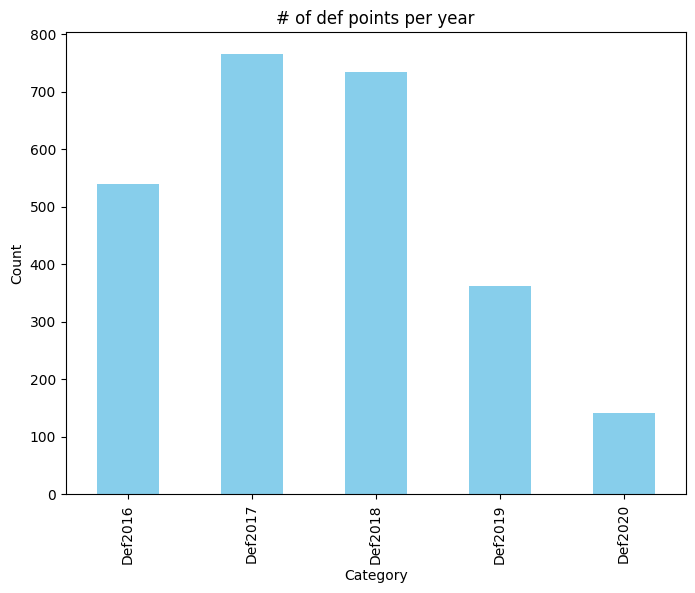

In [43]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020']

# Filter the DataFrame to include only the selected values
filtered_df = esbae_ceo[esbae_ceo['Ref_Change_Year_1520'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Ref_Change_Year_1520'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

##### plot degradation points by year

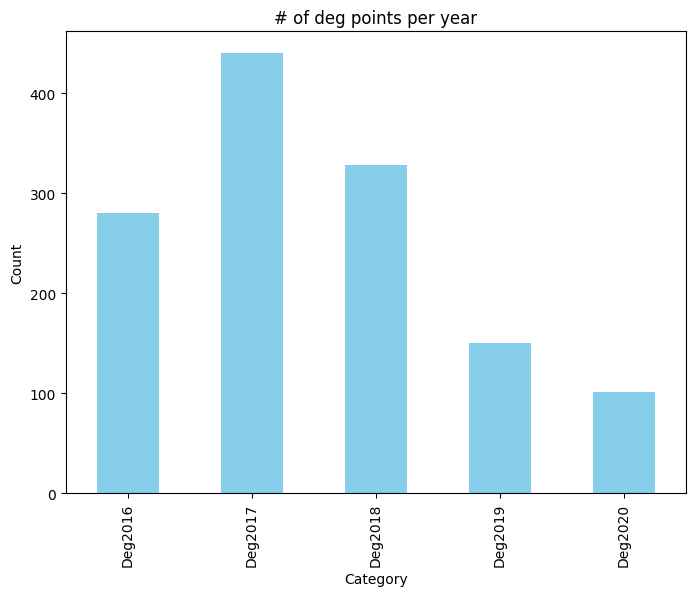

In [44]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020']

# Filter the DataFrame to include only the selected values
filtered_df = esbae_ceo[esbae_ceo['Ref_Change_Year_1520'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
degvalue_counts = filtered_df['Ref_Change_Year_1520'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
degvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [45]:
print(esbae_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ccdc_change_date' 'ccdc_magnitude' 'aspect' 'dw_class_mode'
 'dw_tree_prob__max' 'dw_tree_prob__min' 'dw_tree_prob__stdDev'
 'dw_tree_prob_mean' 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17'
 'esri_lc18' 'esri_lc19' 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss'
 'gfc_lossyear' 'gfc_tc00' 'lang_tree_height' 'potapov_tree_height'
 'slope' 'tmf_2016' 'tmf_2017' 'tmf_20

In [46]:
merged_annual_counts = esbae_ceo['Ref_Change_Year_1520'].value_counts()
merged_annual_counts = merged_annual_counts.sort_index()
merged_annual_counts

Ref_Change_Year_1520
Def2016     539
Def2017     765
Def2018     734
Def2019     362
Def2020     141
Deg2016     280
Deg2017     440
Deg2018     328
Deg2019     150
Deg2020     101
NF         4606
Stable     4669
Name: count, dtype: int64

In [47]:
esbae_ceo.describe()

,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,red_min,red_max,nir_mean,nir_sd,nir_min,nir_max,swir1_mean,swir1_sd,swir1_min,swir1_max,swir2_mean,swir2_sd,swir2_min,swir2_max,ndfi_mean,ndfi_sd,ndfi_min,ndfi_max,brightness_mean,brightness_sd,brightness_min,brightness_max,greenness_mean,greenness_sd,greenness_min,greenness_max,wetness_mean,wetness_sd,wetness_min,wetness_max,bs_slope_mean,bs_slope_sd,bs_slope_max,bs_slope_min,ccdc_change_date,ccdc_magnitude,aspect,dw_class_mode,dw_tree_prob__max,dw_tree_prob__min,dw_tree_prob__stdDev,dw_tree_prob_mean,elevation,esa_lc20,esa_lc21,esri_lc17,esri_lc18,esri_lc19,esri_lc20,esri_lc21,gfc_gain,gfc_loss,gfc_lossyear,gfc_tc00,lang_tree_height,potapov_tree_height,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,OID_,PLOTID,LON,LAT,CEO_Ref_Co,Ref_FNF_2015,Ref_LCtype,Ref_Year,countDrivers,Ref_InfraR,Ref_Urb,Ref_ArtAg,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Ref_Change_1520,collection,interpreted,Def2016,Def2017,Def2018,Def2019,Def2020,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Defall,Degall,Stable,NF
count,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,1.311500e+04,13115.000000,13115.000000,13115.000000,13115.000000,13031.000000,13019.000000,13019.000000,13019.000000,13019.000000,13019.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13030.000000,13031.000000,13031.000000,13031.000000,5317.000000,13031.000000,12895.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,3840.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.0,13115.0,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.00000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000
mean,6558.024552,132.418147,78.613420,1863.019480,-1037.548040,-1.599384e+07,2018.415474,0.352812,52419.001478,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,5539.360354,2745.945325,-206.846761,9642.287276,-80.643652,1.506222e+02,406.517921,-576.152187,1248.913343,-733.984595,178.730719,1.843306,69.742377,12.589907,14.280820,46.794531,748.066131,21.136521,20.633489,4.221165,4.719899,4.833781,4.854259,4.852352,0.007290,0.340649,15.660899,59.066150,15.130050,9.109355,5.002379,3.681222,3.742460,3.803162,3.829714,3.840457,432.714047,302.825167,45.928402,56.539636,6557.000000,167870.325963,19.508425,0.176108,59.902783,0.648799,7.996111,2017.519010,0.776210,0.151735,0.114602,0.254594,0.023332,0.152116,0.026763,0.013725,0.004804,0.034541,0.292795,1.0,1.0,0.041098,0.058330,0.055966,0.027602,0.010751,0.021350,0.033549,0.02501,0.011437,0.007701,0.193748,0.099047,0.356005,0.351201
std,3786.160211,57.824750,35.421002,536.428645,2550.876589,8.461920e+08,1.414568,0.184333,48135.855925,3766.123950,1985.163289,6450.389582,756.504508,3766.123950,1985.163

In [48]:
print(esbae_ceo.dtypes)

geometry                geometry
UniqueID                   int64
images                     int64
mon_images                 int64
bfast_change_date        float64
bfast_magnitude          float64
bfast_means              float64
cusum_change_date        float64
cusum_confidence         float64
cusum_magnitude          float64
red_mean                 float64
red_sd                   float64
red_min                  float64
red_max                  float64
nir_mean                 float64
nir_sd                   float64
nir_min                  float64
nir_max                  float64
swir1_mean               float64
swir1_sd                 float64
swir1_min                float64
swir1_max                float64
swir2_mean               float64
swir2_sd                 float64
swir2_min                float64
swir2_max                float64
ndfi_mean                float64
ndfi_sd                  float64
ndfi_min                 float64
ndfi_max                 float64
brightness

##### export merged esbae and ceo data to one csv file for next step

In [53]:
# if you want to remove all the eSBAE variables
#DRC
#esbae = esbae[['point_id', 'PLOTID', 'LAT','LON','stratum', 'chg_prob', 'simple_combined','NOM']]
#GAB
#esbae = esbae[['point_id', 'PLOTID', 'LAT','LON','stratum', 'chg_prob', 'simple_combined']]

In [49]:
esbae_ceo_data_out =  '/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_merge.csv'
esbae_ceo.to_csv(esbae_ceo_data_out,index=False)
#OR
#esbae_ceo[esbae_ceo_columns].to_csv(data_out,index=True)